In [367]:
from tqdm import tqdm
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

При чтении будем хранить данные в переменной `CACHE`, чтобы ускорить загрузку. В случае их обновления, достаточно вызвать `read(override=True)`

In [288]:
SMALL_DATASET_DIR = './data/notMNIST_small/'
LARGE_DATASET_DIR = './data/notMNIST_large/'
CACHE = {}

In [297]:
def read(data_dir, override=False):
    global CACHE
    if not CACHE.get(data_dir, []) or override:
        CACHE[data_dir] = []
        X, y = [], []
        for f in tqdm(os.listdir(data_dir), desc='Letter'):
            if not f.startswith('.'):
                img_dir = os.path.join(data_dir, f)
                for img in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img)
                    data = cv2.imread(img_path, 0)
                    if data is None:
                        continue
                    s = pd.Series(data.reshape((28*28,)))
                    X.append(s)
                    y.append(f)
        CACHE[data_dir].append(pd.DataFrame(X))
        CACHE[data_dir].append(pd.DataFrame(y))
    return CACHE[data_dir][0], CACHE[data_dir][1]

Удостоверимся, что данные такие, какими их и ожидали:

In [298]:
def get_data(data_dir, verbose=False):
    X, y = read(data_dir)
    assert X.shape[0] == y.shape[0]
    N = X.shape[0]
    if verbose:
        print(X.shape)
        print(y.shape)
        print(X[:5])
        print(y[:5])
        print(np.unique(y))
    return X, y

In [412]:
X_small, y_small = shuffle(*get_data(SMALL_DATASET_DIR, verbose=True), random_state=6)
X_large, y_large = shuffle(*get_data(LARGE_DATASET_DIR, verbose=True), random_state=6)

(18724, 784)
(18724, 1)
   0    1    2    3    4    5    6    7    8    9   ...   774  775  776  777  \
0  152  172  216  240  251  255  255  255  255  255 ...   255  255  255  255   
1    0    0    0    0    0    0    0    0    3    0 ...     0    0    0    0   
2    0    0    0    0    0    0    1    1    0  190 ...    62    0    2    0   
3  255  255  255  255  255  255  255  255  255  255 ...   255  255  255  255   
4  183  183  183  183  183  183  183  183  183  183 ...   255  255  255  255   

   778  779  780  781  782  783  
0  255  252  243  221  179  160  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3  255  255  255  255  255  255  
4  255  255  255  255  255  255  

[5 rows x 784 columns]
   0
0  I
1  I
2  I
3  I
4  I
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J']
(529114, 784)
(529114, 1)
   0    1    2    3    4    5    6    7    8    9   ...   774  775  776  777  \
0  112  149  180  199  214  229  224  215  197  176 ...     0    0    0    0   
1    0   

Отрисуем некоторые считанные картинки:

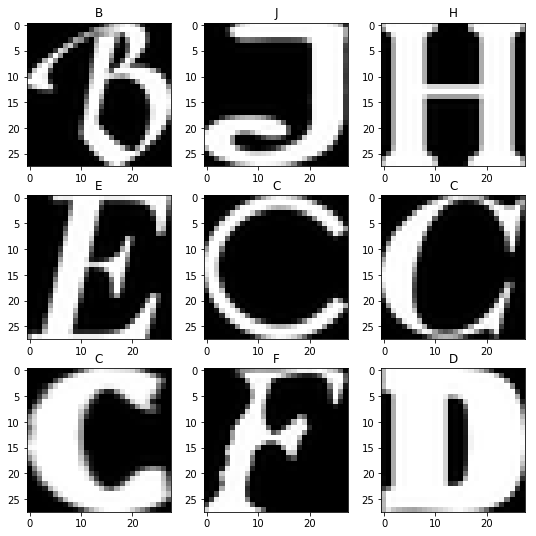

In [414]:
fig, ax = plt.subplots(3, 3, figsize=(9, 9))
for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        ax[i][j].set_title(y_small.iloc[idx][0])
        ax[i][j].imshow(np.array(X_small.iloc[idx]).reshape((28, 28)), cmap='gray')

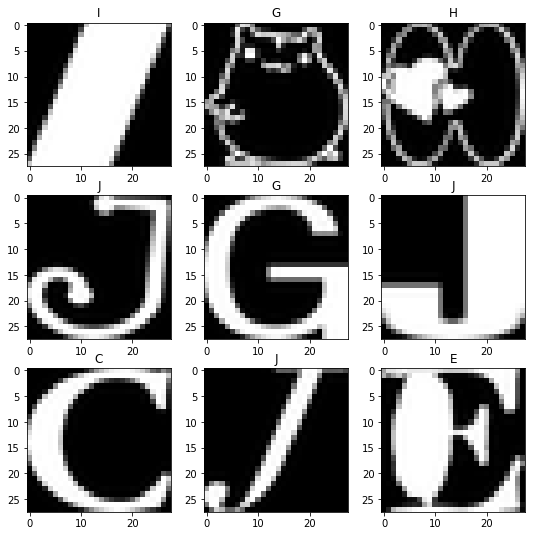

In [416]:
fig, ax = plt.subplots(3, 3, figsize=(9, 9))
for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        ax[i][j].set_title(y_large.iloc[idx][0])
        ax[i][j].imshow(np.array(X_large.iloc[idx]).reshape((28, 28)), cmap='gray')

Проверим распределение классов на выборке:

In [417]:
y_small[0].value_counts()

B    1873
C    1873
E    1873
D    1873
J    1872
G    1872
I    1872
H    1872
F    1872
A    1872
Name: 0, dtype: int64

In [418]:
y_large[0].value_counts()

H    52912
E    52912
F    52912
I    52912
C    52912
G    52912
B    52911
J    52911
D    52911
A    52909
Name: 0, dtype: int64

Как видно, распределение по объектам равномерное

Разделим "large data" на обучающую и валидационную выборки:

In [443]:
X_train, X_val, y_train, y_val = train_test_split(X_large[:210000], y_large[:210000], test_size=0.05)
X_train, y_train = shuffle(X_train, y_train, random_state=6)
X_val, y_val = shuffle(X_val, y_val, random_state=6)
print(X_train.shape)
print(X_val.shape)

(199500, 784)
(10500, 784)



По предположению, "large" и "small" датасеты имеют нулевое пересечение. По построению (`train_test_split` также дает непересекающие подвыборки) `train` и `val` выборки не пересекаются

In [448]:
def try_classifier(X_train, y_train, X_test, y_test, **params):
    classifier = LogisticRegression(solver='sag', multi_class='multinomial', n_jobs=-1, random_state=6, **params)
    classifier.fit(X_train, y_train)
    return classifier, classifier.score(X_test, y_test)

def try_different(**params):
    val_scores = []
    test_scores = []
    clfs = []
    Ns = np.linspace(5000, 200000, 10)
    for N in tqdm(Ns):
        N = int(N)
        print(f'Classifying {N}')
        N_val = X_val.shape[0] * N // X_train.shape[0]
        print('Train:', N)
        print(y_train[:N][0].value_counts())
        print('Val:', N_val)
        print(y_val[:N_val][0].value_counts())
        clf, score = try_classifier(X_train[:N], y_train[:N][0].ravel(), X_val[:N_val], y_val[:N_val][0].ravel(), **params)
        val_scores.append(score)
        N_test = X_small.shape[0] * N // X_train.shape[0]
        print('Test:', N_test)
        print(y_small[:N_test][0].value_counts())
        test_scores.append(clf.score(X_small[:N_test], y_small[:N_test][0].ravel()))
        clfs.append(clf)
    return clfs, Ns, val_scores, test_scores

In [449]:
def viz_clf(clfs, Ns, val_scores, test_scores):
    plt.title('Scores')
    plt.xlabel('N')
    plt.ylabel('Score')
    plt.plot(Ns, val_scores, color='green', label='CV')
    plt.plot(Ns, test_scores, color='red', label='Test')
    plt.legend()
    plt.show()

















  0%|          | 0/10 [00:00<?, ?it/s]

Classifying 5000
Train: 5000
B    540
J    514
D    512
C    510
A    506
E    505
I    487
G    478
H    476
F    472
Name: 0, dtype: int64
Val: 263
G    36
H    34
C    33
I    28
F    27
J    24
B    23
D    23
A    18
E    17
Name: 0, dtype: int64


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
















 10%|█         | 1/10 [00:01<00:17,  1.92s/it]

Test: 469
C    59
J    53
G    52
I    50
B    49
H    45
F    43
E    42
A    41
D    35
Name: 0, dtype: int64
Classifying 26666
Train: 26666
B    2758
A    2750
H    2739
J    2736
I    2639
D    2630
C    2620
G    2620
E    2600
F    2574
Name: 0, dtype: int64
Val: 1403
I    157
C    155
G    154
F    143
H    139
A    138
E    135
J    132
B    130
D    120
Name: 0, dtype: int64


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
















 20%|██        | 2/10 [00:12<00:35,  4.43s/it]

Test: 2502
J    266
C    262
F    260
I    258
E    256
B    252
A    247
G    235
H    234
D    232
Name: 0, dtype: int64
Classifying 48333
Train: 48333
B    4948
H    4911
J    4903
A    4882
G    4834
D    4791
I    4771
F    4766
E    4765
C    4762
Name: 0, dtype: int64
Val: 2543
C    275
I    274
G    263
E    261
B    258
H    251
A    246
F    244
D    237
J    234
Name: 0, dtype: int64


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
















 30%|███       | 3/10 [00:29<00:57,  8.28s/it]

Test: 4536
C    475
J    473
F    465
I    456
B    454
H    454
A    453
E    447
G    430
D    429
Name: 0, dtype: int64
Classifying 70000
Train: 70000
G    7095
J    7092
H    7067
B    7066
C    7016
A    7003
I    6964
F    6913
D    6909
E    6875
Name: 0, dtype: int64
Val: 3684
I    412
C    388
E    378
B    374
A    369
J    363
H    360
F    352
G    351
D    337
Name: 0, dtype: int64


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
















 40%|████      | 4/10 [00:54<01:19, 13.25s/it]

Test: 6569
C    694
F    680
B    667
I    665
J    662
A    653
H    651
E    638
G    630
D    629
Name: 0, dtype: int64
Classifying 91666
Train: 91666
J    9310
G    9244
B    9234
H    9214
C    9189
A    9183
D    9124
F    9092
I    9065
E    9011
Name: 0, dtype: int64
Val: 4824
I    524
C    498
J    497
E    494
G    481
A    476
H    475
B    473
F    467
D    439
Name: 0, dtype: int64


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
















 50%|█████     | 5/10 [01:27<01:35, 19.19s/it]

Test: 8603
C    918
I    884
B    880
F    879
H    862
J    856
E    844
A    832
G    824
D    824
Name: 0, dtype: int64
Classifying 113333
Train: 113333
J    11486
G    11478
A    11376
B    11366
H    11352
C    11331
I    11277
F    11270
D    11217
E    11180
Name: 0, dtype: int64
Val: 5964
I    623
C    622
J    598
A    598
H    597
G    594
E    589
F    589
B    585
D    569
Name: 0, dtype: int64


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
















 60%|██████    | 6/10 [02:07<01:42, 25.60s/it]

Test: 10636
C    1112
F    1091
B    1079
E    1070
H    1060
J    1057
I    1057
A    1047
G    1032
D    1031
Name: 0, dtype: int64
Classifying 135000
Train: 135000
J    13650
G    13623
A    13599
H    13549
F    13512
B    13486
C    13479
I    13432
D    13376
E    13294
Name: 0, dtype: int64
Val: 7105
I    738
C    728
J    724
E    714
A    713
B    707
F    704
G    702
D    693
H    682
Name: 0, dtype: int64


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
















 70%|███████   | 7/10 [02:55<01:37, 32.34s/it]

Test: 12670
C    1295
F    1279
H    1276
E    1276
J    1273
B    1272
A    1265
D    1261
I    1259
G    1214
Name: 0, dtype: int64
Classifying 156666
Train: 156666
J    15800
H    15787
G    15774
A    15746
B    15711
F    15649
C    15603
I    15588
D    15558
E    15450
Name: 0, dtype: int64
Val: 8245
A    846
I    841
C    840
J    834
E    829
G    824
F    824
B    823
D    808
H    776
Name: 0, dtype: int64


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
















 80%|████████  | 8/10 [03:51<01:18, 39.32s/it]

Test: 14703
C    1521
H    1503
D    1484
B    1477
J    1472
I    1462
A    1456
F    1454
E    1449
G    1425
Name: 0, dtype: int64
Classifying 178333
Train: 178333
G    17997
H    17970
A    17920
B    17872
J    17866
F    17848
C    17805
I    17751
D    17688
E    17616
Name: 0, dtype: int64
Val: 9385
J    969
I    960
A    956
E    953
C    952
F    932
D    927
B    926
G    926
H    884
Name: 0, dtype: int64


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
















 90%|█████████ | 9/10 [04:55<00:46, 46.69s/it]

Test: 16737
C    1708
H    1694
J    1688
D    1682
I    1677
B    1670
E    1669
A    1658
F    1649
G    1642
Name: 0, dtype: int64
Classifying 200000
Train: 200000
G    20104
H    20054
A    20033
B    20023
F    19997
J    19989
I    19887
D    19859
C    19851
E    19703
Name: 0, dtype: int64
Val: 10526
J    1078
A    1078
C    1073
I    1072
E    1060
G    1041
B    1040
D    1037
F    1032
H     989
Name: 0, dtype: int64


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
















100%|██████████| 10/10 [06:06<00:00, 53.95s/it]

















Test: 18770
B    1873
C    1873
E    1873
D    1873
J    1872
G    1872
I    1872
H    1872
F    1872
A    1872
Name: 0, dtype: int64


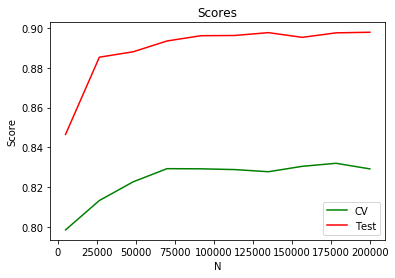

0.8319659030367608
0.8978316599017304


In [450]:
clfs, Ns, val_scores, test_scores = try_different(max_iter=10)
viz_clf(clfs, Ns, val_scores, test_scores)
print(np.max(val_scores))
print(np.max(test_scores))

















  0%|          | 0/10 [00:00<?, ?it/s]

Classifying 5000
Train: 5000
B    540
J    514
D    512
C    510
A    506
E    505
I    487
G    478
H    476
F    472
Name: 0, dtype: int64
Val: 263
G    36
H    34
C    33
I    28
F    27
J    24
B    23
D    23
A    18
E    17
Name: 0, dtype: int64


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
















 10%|█         | 1/10 [00:21<03:14, 21.56s/it]

Test: 469
C    59
J    53
G    52
I    50
B    49
H    45
F    43
E    42
A    41
D    35
Name: 0, dtype: int64
Classifying 26666
Train: 26666
B    2758
A    2750
H    2739
J    2736
I    2639
D    2630
C    2620
G    2620
E    2600
F    2574
Name: 0, dtype: int64
Val: 1403
I    157
C    155
G    154
F    143
H    139
A    138
E    135
J    132
B    130
D    120
Name: 0, dtype: int64


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
















 20%|██        | 2/10 [01:58<05:52, 44.05s/it]

Test: 2502
J    266
C    262
F    260
I    258
E    256
B    252
A    247
G    235
H    234
D    232
Name: 0, dtype: int64
Classifying 48333
Train: 48333
B    4948
H    4911
J    4903
A    4882
G    4834
D    4791
I    4771
F    4766
E    4765
C    4762
Name: 0, dtype: int64
Val: 2543
C    275
I    274
G    263
E    261
B    258
H    251
A    246
F    244
D    237
J    234
Name: 0, dtype: int64


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
















 30%|███       | 3/10 [04:42<09:21, 80.25s/it]

Test: 4536
C    475
J    473
F    465
I    456
B    454
H    454
A    453
E    447
G    430
D    429
Name: 0, dtype: int64
Classifying 70000
Train: 70000
G    7095
J    7092
H    7067
B    7066
C    7016
A    7003
I    6964
F    6913
D    6909
E    6875
Name: 0, dtype: int64
Val: 3684
I    412
C    388
E    378
B    374
A    369
J    363
H    360
F    352
G    351
D    337
Name: 0, dtype: int64


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
















 40%|████      | 4/10 [08:43<12:49, 128.26s/it]

Test: 6569
C    694
F    680
B    667
I    665
J    662
A    653
H    651
E    638
G    630
D    629
Name: 0, dtype: int64
Classifying 91666
Train: 91666
J    9310
G    9244
B    9234
H    9214
C    9189
A    9183
D    9124
F    9092
I    9065
E    9011
Name: 0, dtype: int64
Val: 4824
I    524
C    498
J    497
E    494
G    481
A    476
H    475
B    473
F    467
D    439
Name: 0, dtype: int64


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
















 50%|█████     | 5/10 [13:56<15:19, 183.81s/it]

Test: 8603
C    918
I    884
B    880
F    879
H    862
J    856
E    844
A    832
G    824
D    824
Name: 0, dtype: int64
Classifying 113333
Train: 113333
J    11486
G    11478
A    11376
B    11366
H    11352
C    11331
I    11277
F    11270
D    11217
E    11180
Name: 0, dtype: int64
Val: 5964
I    623
C    622
J    598
A    598
H    597
G    594
E    589
F    589
B    585
D    569
Name: 0, dtype: int64


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
















 60%|██████    | 6/10 [20:24<16:20, 245.10s/it]

Test: 10636
C    1112
F    1091
B    1079
E    1070
H    1060
J    1057
I    1057
A    1047
G    1032
D    1031
Name: 0, dtype: int64
Classifying 135000
Train: 135000
J    13650
G    13623
A    13599
H    13549
F    13512
B    13486
C    13479
I    13432
D    13376
E    13294
Name: 0, dtype: int64
Val: 7105
I    738
C    728
J    724
E    714
A    713
B    707
F    704
G    702
D    693
H    682
Name: 0, dtype: int64


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
















 70%|███████   | 7/10 [28:16<15:39, 313.02s/it]

Test: 12670
C    1295
F    1279
H    1276
E    1276
J    1273
B    1272
A    1265
D    1261
I    1259
G    1214
Name: 0, dtype: int64
Classifying 156666
Train: 156666
J    15800
H    15787
G    15774
A    15746
B    15711
F    15649
C    15603
I    15588
D    15558
E    15450
Name: 0, dtype: int64
Val: 8245
A    846
I    841
C    840
J    834
E    829
G    824
F    824
B    823
D    808
H    776
Name: 0, dtype: int64


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
















 80%|████████  | 8/10 [37:14<12:41, 380.76s/it]

Test: 14703
C    1521
H    1503
D    1484
B    1477
J    1472
I    1462
A    1456
F    1454
E    1449
G    1425
Name: 0, dtype: int64
Classifying 178333
Train: 178333
G    17997
H    17970
A    17920
B    17872
J    17866
F    17848
C    17805
I    17751
D    17688
E    17616
Name: 0, dtype: int64
Val: 9385
J    969
I    960
A    956
E    953
C    952
F    932
D    927
B    926
G    926
H    884
Name: 0, dtype: int64


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
















 90%|█████████ | 9/10 [47:32<07:31, 451.81s/it]

Test: 16737
C    1708
H    1694
J    1688
D    1682
I    1677
B    1670
E    1669
A    1658
F    1649
G    1642
Name: 0, dtype: int64
Classifying 200000
Train: 200000
G    20104
H    20054
A    20033
B    20023
F    19997
J    19989
I    19887
D    19859
C    19851
E    19703
Name: 0, dtype: int64
Val: 10526
J    1078
A    1078
C    1073
I    1072
E    1060
G    1041
B    1040
D    1037
F    1032
H     989
Name: 0, dtype: int64


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
















100%|██████████| 10/10 [58:57<00:00, 521.84s/it]

















Test: 18770
B    1873
C    1873
E    1873
D    1873
J    1872
G    1872
I    1872
H    1872
F    1872
A    1872
Name: 0, dtype: int64


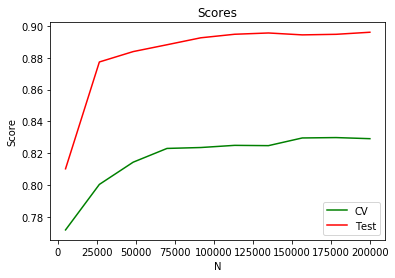

0.8298348428343101
0.8959624011963255


In [451]:
clfs, Ns, val_scores, test_scores = try_different(max_iter=100)
viz_clf(clfs, Ns, val_scores, test_scores)
print(np.max(val_scores))
print(np.max(test_scores))